# Human Resource Analytics

This exercise is mainly for practicing data cleaning, EDA and simple models. 
***Our goal is to understand what factors contribute most to employee turnover and create a model that can predict if a certain employee will leave the company or not***
- Dataset is about human resource analytics.
- Targets are boolean, if employees stay or left the company.
- The variables are satisfaction_level, last_evaluation, numbers of project, average monthly hours on working, time spend on company, work accidents that occured, promition within the last 5 years, department, salary.


In [95]:
import math
import os 
import warnings
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [58]:
#loading data:
df=pd.read_csv(r"hr.csv")

In [59]:
#rename cols
df=df.rename(columns={'sales':"department"})
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [60]:
#check the data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [61]:
#check missing values data cleansing 
df.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
department               False
salary                   False
dtype: bool

In [62]:
#shorten the col names
df = df.rename(columns={
                        'promotion_last_5years': 'promotion',
                        'sales' : 'department',
                        'left' : 'left'
                        })

In [63]:
##move left columns to the front
front=df['left']
df.drop(labels='left',axis=1,inplace=True)
df.insert(0,'left',front)
df.head()

,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion,department,salary
0,1,0.38,0.53,2,157,3,0,0,sales,low
1,1,0.80,0.86,5,262,6,0,0,sales,medium
2,1,0.11,0.88,7,272,4,0,0,sales,medium
3,1,0.72,0.87,5,223,5,0,0,sales,low
4,1,0.37,0.52,2,159,3,0,0,sales,low


In [64]:
# Summary of the data set:
turnover_rate = df.left.value_counts() / 14999
print('Turnover rate:\n',turnover_rate)
df.describe()

Turnover rate:
 0    0.761917
1    0.238083
Name: left, dtype: float64


,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.238083,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268
std,0.425924,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281
min,0.000000,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000
25%,0.000000,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000
50%,0.000000,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000
75%,0.000000,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000


The dataset has:

- About 15,000 employee observations and 10 features

- The company had a turnover rate of about 24%

- Mean satisfaction of employees is 0.61
- Monthly hours are around 200 hours

## EDA
1. Correlation metrics:

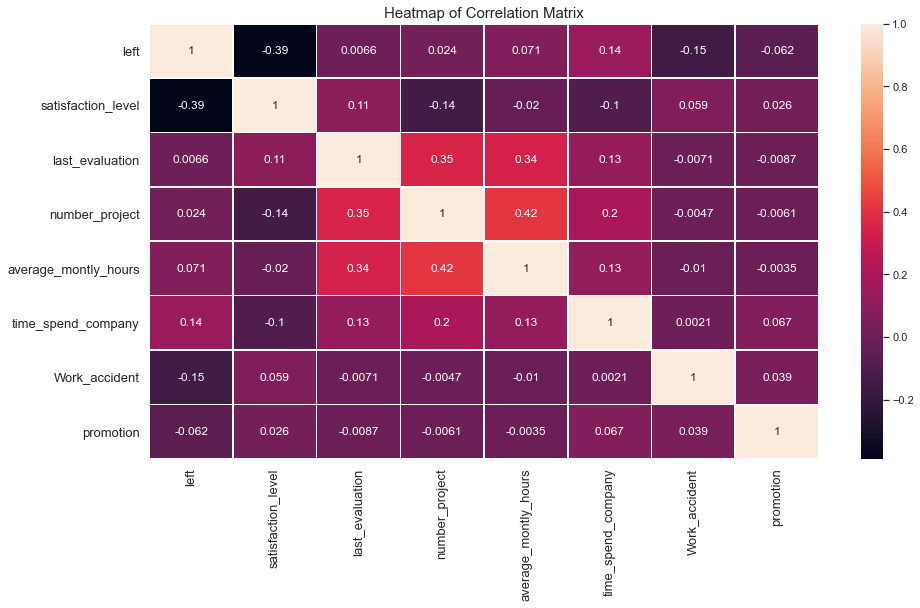

In [65]:
#1. Correlation metrics:
corr=df.corr()
sns.set(font_scale=1)
plt.figure(figsize=(15,8))
ax=sns.heatmap(df.corr(),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, 
            annot=True, 
            linewidths=.5
#             cmap="YlGnBu", 
)

ax.set_title('Heatmap of Correlation Matrix', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), size=13)
ax.set_yticklabels(ax.get_yticklabels(), size=13)
plt.show()

As we can see from the correlation metrix:
- The turnover rate has a strong negative relationship with statisfication rate.
- Numbers of projects and statisfication rate has a strong negative relationship as well.
- The more project a person have, the longer working hours they have

- From the heatmap, we can see that number_project, 
average_monthly_hours and last_evaluation have a strong positive correlation.
It tells us if employees spent more time on work and completed more numbers of porject, 
the evlaution will be better.

- For the negative aspects,
satisfiction level, work_accident, left and numbers of project have a negative correlation.
It means more work_accident and more projects, the satisfication level will be lower, so that they have more chance to leave the company.


2. Distribution of people in defferent department

C:\Users\Rachel\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Rachel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


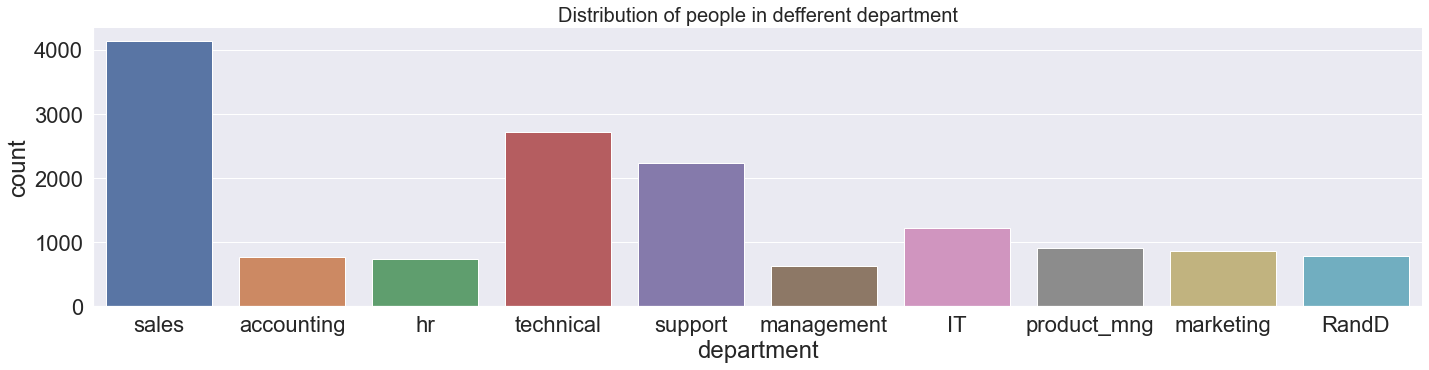

In [66]:
sns.set(font_scale=2)
g=sns.factorplot('department',kind='count',aspect=4, data=df)
#g.set_xticklabels(rotation=90)
g = plt.title("Distribution of people in defferent department", size=20)
plt.show()

As we can see that:
- Sales, technical, support have the most employees.

3. Numbers of projects distribution

<AxesSubplot:xlabel='number_project'>

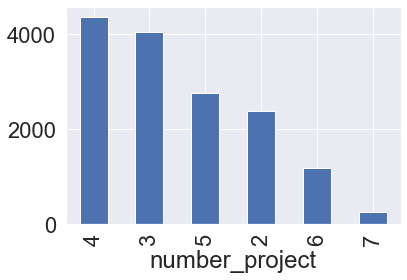

In [67]:
df.groupby('number_project').size().sort_values(ascending=False).plot(kind='bar')

- By average, people have 4 projects in total

4. Reasons for leaving

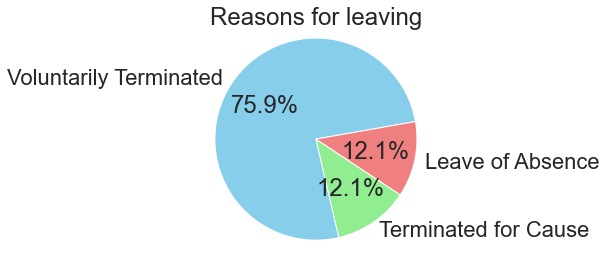

In [68]:
plt.figure(figsize=(4,4))
labels = 'Voluntarily Terminated', 'Terminated for Cause', 'Leave of Absence'
sizes = [88, 14, 14]
colors = ['skyblue', 'lightgreen', 'lightcoral']
plt.pie(sizes,               
        labels=labels,      
        colors=colors,      
        autopct='%1.1f%%',  
        startangle=10
        )

plt.axis('equal')
plt.title('Reasons for leaving')

plt.show()

In [69]:
df.columns

Index(['left', 'satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion', 'department', 'salary'],
      dtype='object')

C:\Users\Rachel\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


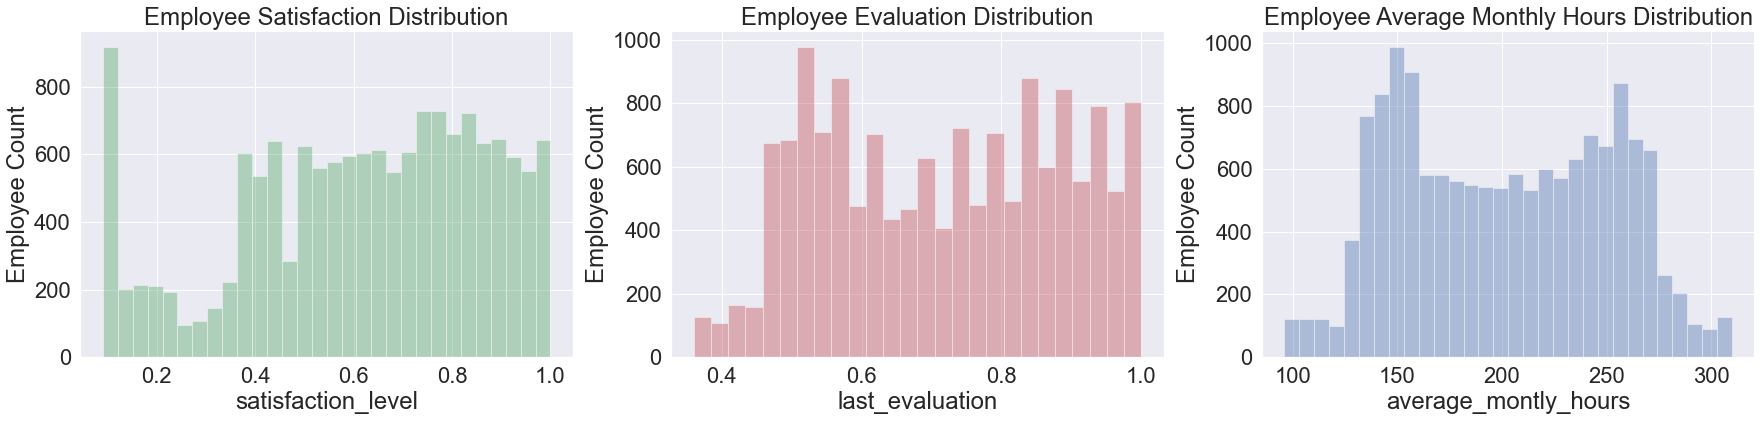

In [70]:
# Set up the matplotlib figure
f, axes = plt.subplots(ncols=3, figsize=(30, 6))
# Graph Employee Satisfaction
sns.distplot(df.satisfaction_level, kde=False, color="g", ax=axes[0]).set_title('Employee Satisfaction Distribution')
axes[0].set_ylabel('Employee Count')
# Graph Employee Evaluation
sns.distplot(df.last_evaluation, kde=False, color="r", ax=axes[1]).set_title('Employee Evaluation Distribution')
axes[1].set_ylabel('Employee Count')
# Graph Employee Average Monthly Hours
sns.distplot(df.average_montly_hours, kde=False, color="b", ax=axes[2]).set_title('Employee Average Monthly Hours Distribution')
axes[2].set_ylabel('Employee Count')
plt.show()

In [72]:
##To check the unique numbers of department and salary
df1=df["department"].unique()
df2=df["salary"].unique()
# #department, salary convert into numbers
# df.replace(df1, np.arange(10), inplace=True)
# df.replace(df2, [0,1,2], inplace=True)

In [73]:
df.left.value_counts()

0    11428
1     3571
Name: left, dtype: int64

<AxesSubplot:ylabel='left'>

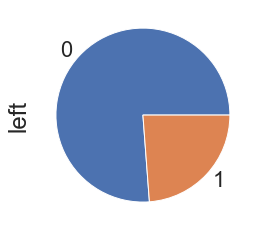

In [75]:
#left rate
left_rate=df.left.value_counts()/14999
left_rate.plot(kind='pie')
#76% stay

In [76]:
#### starting analysis
left_summary=df.groupby('left')
left_summary.mean().applymap(decimal)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion
left,,,,,,,
0,0.67,0.72,3.79,199.06,3.38,0.18,0.03
1,0.44,0.72,3.86,207.42,3.88,0.05,0.01


In [77]:
new=df.groupby(['left', 'department'])['department'].count().to_frame()
new

department
left department             
0    IT                  954
     RandD               666
     accounting          563
     hr                  524
     management          539
     marketing           655
     product_mng         704
     sales              3126
     support            1674
     technical          2023
1    IT                  273
     RandD               121
     accounting          204
     hr                  215
     management           91
     marketing           203
     product_mng         198
     sales              1014
     support             555
     technical           697

In [78]:
# 3). analysis of attributes
##department  vs  left
depart_left_table=pd.crosstab(index=df['department'],columns=df['left'])
depart_sum=df.groupby(['department']).sum()
depart_sum

,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion
department,,,,,,,,
IT,273,758.46,879.55,4683,248119,4256,164,3
RandD,121,487.80,560.44,3033,158030,2650,134,27
accounting,204,446.51,550.49,2934,154292,2702,96,14
hr,215,442.52,523.84,2701,146828,2480,89,15
management,91,391.45,456.12,2432,126787,2711,103,69
marketing,203,530.76,614.23,3164,171073,3063,138,43
product_mng,198,558.91,644.71,3434,180369,3135,132,0
sales,1014,2543.81,2938.23,15634,831773,14631,587,100
support,555,1378.19,1611.81,8479,447490,7563,345,20


In [79]:
depart_left_table=pd.crosstab(index=df['department'],columns=df['left'])

In [80]:
depart_left_table

left,0,1
department,,
IT,954,273
RandD,666,121
accounting,563,204
hr,524,215
management,539,91
marketing,655,203
product_mng,704,198
sales,3126,1014
support,1674,555


In [81]:
left_rate=depart_left_table[1]/sum(depart_left_table[0], depart_left_table[1])
left_rate

department
IT             0.023331
RandD          0.010477
accounting     0.017538
hr             0.018466
management     0.007900
marketing      0.017453
product_mng    0.017031
sales          0.081498
support        0.046316
technical      0.057485
Name: 1, dtype: float64

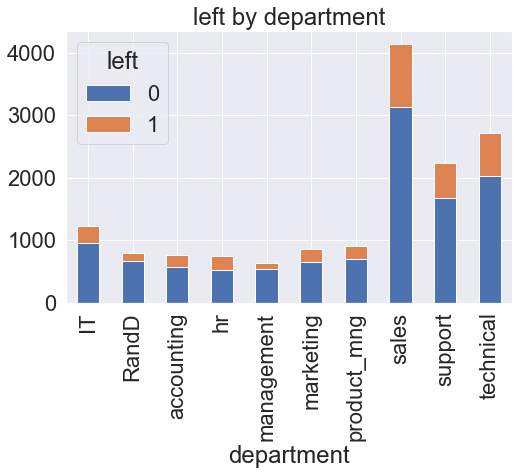

In [82]:
##jobs：'sales', 'accounting', 'hr', 'technical', 'support', 'management','IT', 'product_mng', 'marketing', 'RandD'
left_rate=depart_left_table[1]/sum(depart_left_table[0], depart_left_table[1])
ax=depart_left_table.plot(kind='bar',figsize=(8,5),stacked=True, title="left by department")


<AxesSubplot:xlabel='average_montly_hours', ylabel='Density'>

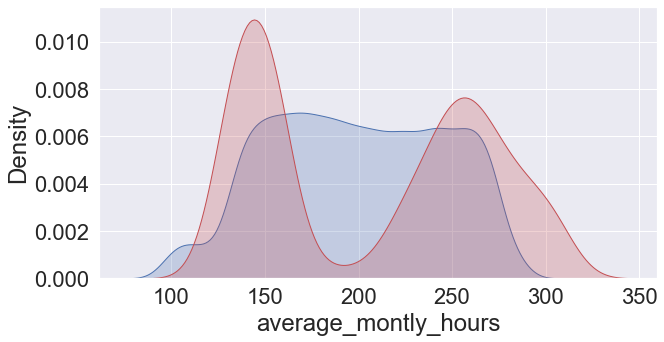

In [83]:
##average_montly_hours vs left
hours_left_table=pd.crosstab(index=df['average_montly_hours'],columns=df['left'])
fig=plt.figure(figsize=(10,5))
sns.kdeplot(df.loc[(df['left']==0),'average_montly_hours'],color='b',shade=True,label='no left')
sns.kdeplot(df.loc[(df['left']==1),'average_montly_hours'],color='r',shade=True,label='left')

<AxesSubplot:xlabel='department'>

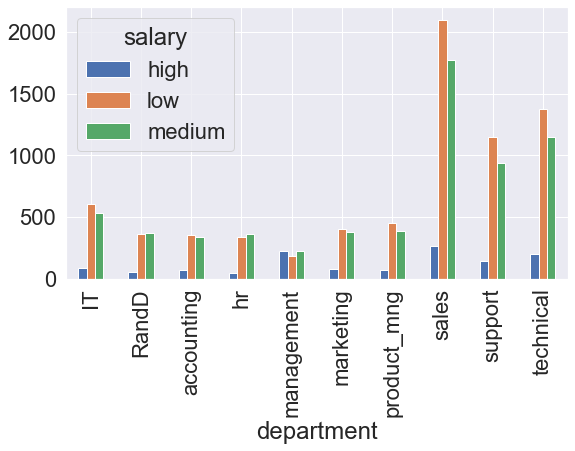

In [84]:
#department  vs  salary

depart_salary_table=pd.crosstab(index=df['department'],columns=df['salary'])
depart_salary_table.plot(kind="bar",figsize=(9,5),stacked=False)



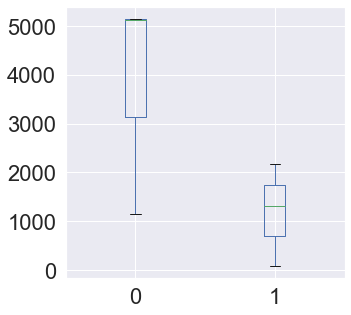

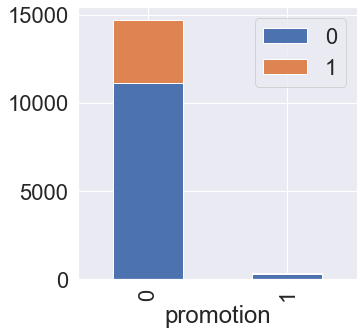

In [85]:
##salary  vs left
salary_left_table=pd.crosstab(index=df['salary'],columns=df['left'])
salary_left_table.plot(kind='box',figsize=(5,5),stacked=True)
## High salary are more likely to stay


##promotion  vs  left
promotion_left_table=pd.crosstab(index=df['promotion'],columns=df['left'])
promotion_left_table.plot(kind='bar',figsize=(5,5),stacked=True)
plt.legend()
## People who got promotion are more likely to stay

<AxesSubplot:xlabel='number_project'>

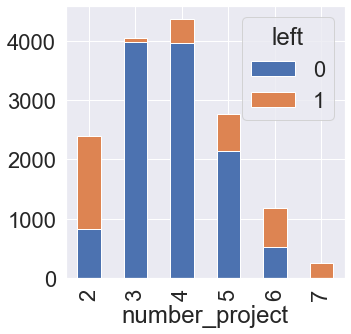

In [86]:
##number_project  vs  left
project_left_table=pd.crosstab(index=df['number_project'],columns=df['left'])
project_left_table.plot(kind='bar',figsize=(5,5),stacked=True)
# df.loc[(df['left']==1),'number_project'].plot(kind='hist',bins=15,stacked=False,alpha=1)
##From this plot we know that people who have too many projects or only one project are easy to leave

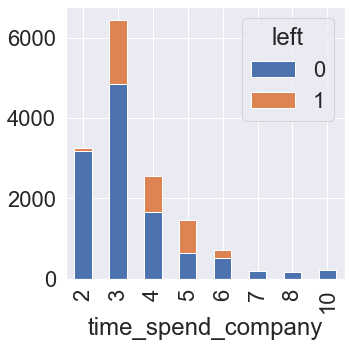

In [87]:
##time_spend_company  vs  left
company_left_table=pd.crosstab(index=df['time_spend_company'],columns=df['left'])
company_left_table.plot(kind='bar',figsize=(5,5),stacked=True);
# df.loc[(df['left']==1),'time_spend_company'].plot(kind='hist',bins=10,stacked=False,alpha=0.3)

# More time you spend on the company, more chances to stay

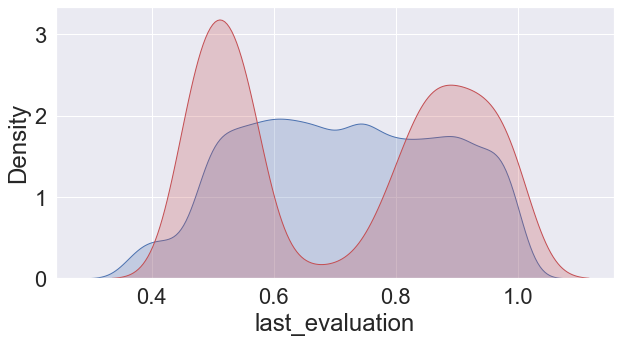

In [88]:
##last_evaluation  vs  left
evaluation_left_table=pd.crosstab(index=df['last_evaluation'],columns=df['left'])
fig=plt.figure(figsize=(10,5))
left=sns.kdeplot(df.loc[(df['left']==0),'last_evaluation'],color='b',shade=True,label='no left')
left=sns.kdeplot(df.loc[(df['left']==1),'last_evaluation'],color='r',shade=True,label='left')
# left.set_title('a')
# left.set_xlabel('b')

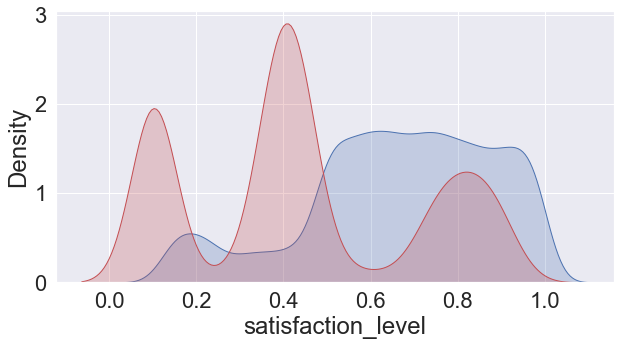

In [89]:
##satisfaction_level  vs  left  
satis_left_table=pd.crosstab(index=df['satisfaction_level'],columns=df['left'])
fig=plt.figure(figsize=(10,5))
left=sns.kdeplot(df.loc[(df['left']==0),'satisfaction_level'],color='b',shade=True,label='no left')
left=sns.kdeplot(df.loc[(df['left']==1),'satisfaction_level'],color='r',shade=True,label='left')

<ipython-input-90-9e6ac3cd43d4>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(df1[['satisfaction_level','last_evaluation']],color='k',ax=ax)


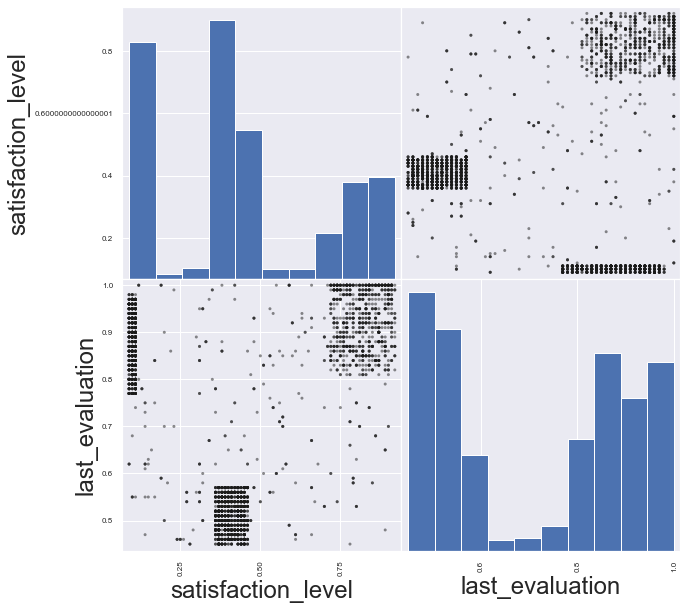

In [90]:
##last_evaluation  vs  satisfaction_level
df1=df[df['left']==1]
fig, ax = plt.subplots(figsize=(10,10))
pd.plotting.scatter_matrix(df1[['satisfaction_level','last_evaluation']],color='k',ax=ax)
plt.show()
# plt.savefig('scatter.png',dpi=1000,bbox_inches='tight')

# Data modeling:
- 1. Get one-hot encoding for categorical data
- 2. Normalization data
- 3. GridSearch to find best model
- 4. Performance decision Tree for baseline
- 5. Optimize model based on XGBoost

In [93]:
#One-hot encoding for category data
df=pd.get_dummies(df)

In [99]:
# Normalization:
scaler = StandardScaler()
scaler.fit_transform(X, y)
# Spliting data set:
X=df.drop(columns={'left'}, axis=1)
y=df.left
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,
                                         random_state=2021)

In [101]:
#Bulid clf
dt_clf = DecisionTreeClassifier(class_weight='balanced')
params_min_samples_split = [5, 10, 15, 20]
params_min_samples_leaf = [2, 4, 6, 8, 10]
params_max_depth = [4, 6, 8, 10]
param_grid_dt = {'min_samples_split' : params_min_samples_split,
                 'min_samples_leaf' : params_min_samples_leaf,
                 'max_depth' : params_max_depth}
#optimization:
grid_dt = GridSearchCV(estimator=dt_clf, param_grid=param_grid_dt, cv=5, scoring='roc_auc')
grid_dt.fit(X_train, y_train)
print('Best parameters:{}'.format(grid_dt.best_params_))
print('Best Score:{}'.format(grid_dt.best_score_))
print('Best Model:{}'.format(grid_dt.best_estimator_))

Best parameters:{'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 20}
Best Score:0.9853932280552309
Best Model:DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [116]:
#build xgboost model，boosteris gbtree，Because 0 and 1 is close to 7:1，set scale_pos_weight for 7
xgb_clf = XGBClassifier(scale_pos_weight=7, eval_metric='auc')
xgb_clf.fit(X_train,y_train)
print('Best model:',xgb_clf.fit(X_train,y_train))

Best model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)


In [118]:

predictions_xgb = xgb_clf.predict(X_test)
# 得到auc结果
rf_roc_auc = roc_auc_score(y_test, predictions_xgb)
# 打印结果
print ("AUC = %2.2f" % rf_roc_auc)
#得出测试结果，生成报告
print('"\n\n ---Results---"')
print(classification_report(y_test, predictions_xgb))

AUC = 0.98
"

 ---Results---"
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2834
           1       0.96      0.97      0.97       916

    accuracy                           0.98      3750
   macro avg       0.98      0.98      0.98      3750
weighted avg       0.98      0.98      0.98      3750



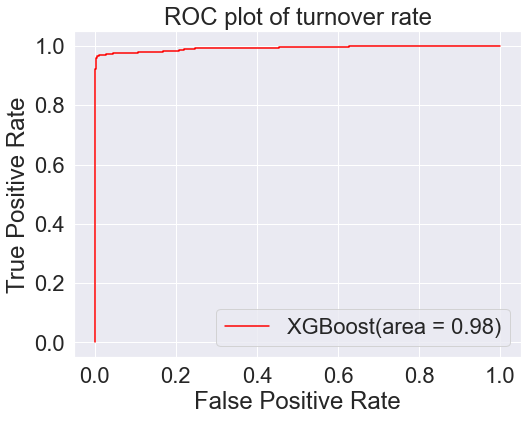

In [124]:
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_clf.predict_proba(X_test)[:,1])
plt.figure(figsize=(8,6))
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost(area = %0.2f)' % rf_roc_auc, color='red')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC plot of turnover rate')
plt.legend(loc="lower right")
plt.show()